<a href="https://colab.research.google.com/github/JakobUniver/Traffic-sign-detection-in-color-videos/blob/main/test_lenet_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

In [ ]:
!ls

README.dataset.txt   test				       valid
README.roboflow.txt  Traffi_and_Road_Signs_v1i_multiclass.zip
sample_data	     train


In [ ]:
!unzip Traffi_and_Road_Signs_v1i_multiclass.zip

Archive:  Traffi_and_Road_Signs_v1i_multiclass.zip
replace README.dataset.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
data_df = pd.read_csv("train/_classes.csv")
data_df = data_df[:2000]

In [ ]:
num_classes = len(data_df.columns)-1
num_classes

29

In [ ]:
(lambda row: cv2.resize(cv2.imread('/content/train/'+row['filename'],cv2.IMREAD_GRAYSCALE), (64,64), interpolation = cv2.INTER_AREA))(data_df.iloc[0]).shape

(64, 64)

In [ ]:
imgs = data_df.apply(lambda row: cv2.imread('/content/train/'+row['filename']), axis=1)
imgs = imgs.apply((lambda img: cv2.resize(img, (64,64), interpolation = cv2.INTER_AREA)))
#,cv2.IMREAD_GRAYSCALE

In [ ]:
imgs = np.array(list(imgs))

In [ ]:
mu = imgs.mean(axis=(0)) # finds mean of R, G and B separately
std = imgs.std(axis=(0)) # same for std
X_norm = (imgs - mu)/std
print(mu, std)

[[[ 98.084  101.5335 104.1165]
  [ 97.591  101.1705 103.629 ]
  [ 98.207  101.907  104.274 ]
  ...
  [100.173  103.8285 106.4665]
  [ 99.689  103.286  106.1855]
  [ 99.7525 103.1265 106.0655]]

 [[ 98.181  101.6025 104.08  ]
  [ 97.9415 101.4115 103.848 ]
  [ 98.4035 102.031  104.364 ]
  ...
  [100.17   103.9335 106.564 ]
  [ 99.694  103.2725 106.135 ]
  [ 99.72   103.037  105.781 ]]

 [[ 98.1015 101.5915 103.8785]
  [ 97.7615 101.305  103.5665]
  [ 97.81   101.5235 103.8275]
  ...
  [100.025  103.7785 106.4865]
  [ 99.4335 103.0135 105.8105]
  [ 99.2115 102.596  105.294 ]]

 ...

 [[ 77.963   80.8055  84.3765]
  [ 77.6115  80.5415  84.124 ]
  [ 77.4715  80.341   84.0515]
  ...
  [ 80.5805  82.3825  85.2155]
  [ 80.15    82.0155  84.8645]
  [ 79.891   81.936   84.7775]]

 [[ 78.0355  80.8195  84.417 ]
  [ 77.4415  80.327   83.8275]
  [ 77.206   80.0845  83.724 ]
  ...
  [ 80.086   81.9115  84.8075]
  [ 79.7815  81.7225  84.5185]
  [ 79.5335  81.5935  84.487 ]]

 [[ 77.769   80.6065  84

In [ ]:
X_norm.shape

(2000, 64, 64, 3)

In [ ]:
img_shape = imgs[0].shape
img_shape

(64, 64, 3)

In [ ]:
#y = data_df.apply(lambda row: [np.where(row.values[1:num_classes+1] == 1)[0][0]], axis=1)
#y = data_df.apply(lambda row: np.where(row.values[1:num_classes+1] == 1)[0][0], axis=1)
y = data_df.apply(lambda row: row.values[1:num_classes+1], axis=1)

In [ ]:
y = np.array(list(y),dtype=bool)

In [ ]:
y

array([[False, False,  True, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False]])

In [ ]:
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy
import tensorflow as tf

In [ ]:
#a = tf.keras.utils.to_categorical(y)

In [ ]:
from keras.models import Sequential
from keras import models, layers
import keras
#Instantiate an empty model
model = Sequential()

model.add(layers.Conv2D(60, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=(img_shape[0],img_shape[1],3 if len(img_shape) == 3 else 1), padding="same"))

model.add(layers.Conv2D(60, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding="valid"))

model.add(MaxPooling2D(pool_size =(2, 2), strides =(2, 2)))

model.add(layers.Conv2D(30, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding="valid"))

model.add(layers.Conv2D(30, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding="same"))


model.add(MaxPooling2D(pool_size =(2, 2), strides =(2, 2),padding='same'))
model.add(Dropout(0.5))

model.add(layers.Flatten())

model.add(layers.Dense(500, activation='tanh'))

model.add(layers.Dense(500, activation='softmax'))
model.add(Dropout(0.5))

model.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy, optimizer='SGD', metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 60)        4560      
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 60)        90060     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 60)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 30)        45030     
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 30)        22530     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 30)       0         
 2D)                                                    

In [ ]:
#downgraded model
from keras.models import Sequential
from keras import models, layers
import keras
#Instantiate an empty model
model = Sequential()

model.add(layers.Conv2D(30, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=(img_shape[0],img_shape[1],3 if len(img_shape) == 3 else 1), padding="same"))

model.add(layers.Conv2D(15, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding="valid"))

model.add(MaxPooling2D(pool_size =(2, 2), strides =(2, 2)))

model.add(layers.Conv2D(10, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding="valid"))

model.add(layers.Conv2D(5, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding="same"))


model.add(MaxPooling2D(pool_size =(2, 2), strides =(2, 2),padding='same'))
model.add(Dropout(0.5))

model.add(layers.Flatten())

model.add(layers.Dense(100, activation='tanh'))

model.add(layers.Dense(100, activation='softmax'))
model.add(Dropout(0.5))

model.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy, optimizer='SGD', metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 64, 64, 30)        2280      
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 15)        11265     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 15)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 26, 26, 10)        3760      
                                                                 
 conv2d_7 (Conv2D)           (None, 26, 26, 5)         1255      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 13, 13, 5)        0         
 2D)                                                  

In [ ]:
history = model.fit(X_norm,y, batch_size=64, epochs=20, validation_split=0.2)

Epoch 1/20
25/25 [==============================] - 44s 2s/step - loss: 3.3652 - accuracy: 0.0512 - val_loss: 3.3650 - val_accuracy: 0.0350
Epoch 2/20
25/25 [==============================] - 44s 2s/step - loss: 3.3636 - accuracy: 0.0400 - val_loss: 3.3628 - val_accuracy: 0.0350
Epoch 3/20
25/25 [==============================] - 43s 2s/step - loss: 3.3610 - accuracy: 0.0487 - val_loss: 3.3606 - val_accuracy: 0.0350
Epoch 4/20
25/25 [==============================] - 43s 2s/step - loss: 3.3582 - accuracy: 0.0487 - val_loss: 3.3585 - val_accuracy: 0.0350
Epoch 5/20
25/25 [==============================] - 43s 2s/step - loss: 3.3558 - accuracy: 0.0594 - val_loss: 3.3564 - val_accuracy: 0.0300
Epoch 6/20
25/25 [==============================] - 43s 2s/step - loss: 3.3544 - accuracy: 0.0544 - val_loss: 3.3543 - val_accuracy: 0.0275
Epoch 7/20
25/25 [==============================] - 43s 2s/step - loss: 3.3518 - accuracy: 0.0625 - val_loss: 3.3522 - val_accuracy: 0.0275
Epoch 8/20
25/25 [==

Text(0.5, 1.0, 'Accuracy')

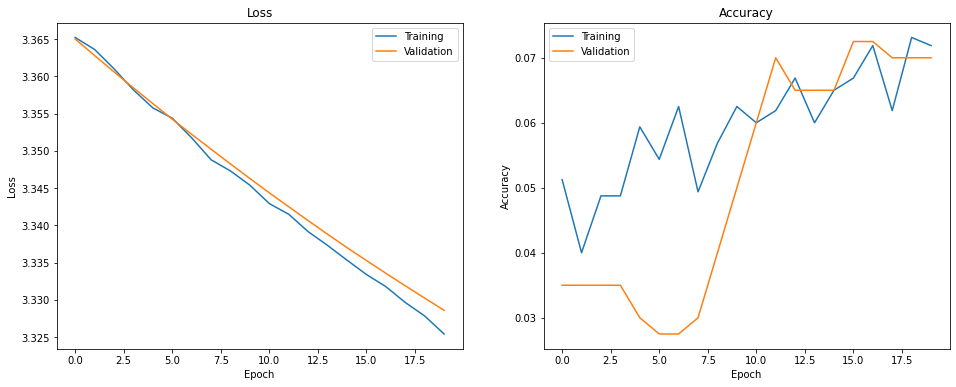

In [ ]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.title('Accuracy')

In [ ]:
# find best parameters with CV

In [ ]:
# train model

In [ ]:
# test model